In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from math import ceil
import matplotlib.pyplot as plt
from argparse import ArgumentParser
import random
from sklearn.manifold import TSNE

from t2_MLP import MLPTrainer, MLP

def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
set_seed(42)
parser = ArgumentParser()
parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu")
parser.add_argument("--epochs", type=int, default= 1e4)
parser.add_argument("--lr", type=float, default=5e-4)
# specific to MLP
parser.add_argument("--mlp_layers", type=int, default=4)
parser.add_argument("--mlp_embd_dim", type=int, default=64)
parser.add_argument("--mlp_hid_dim", type=int, default=128)
parser.add_argument("--MLP_optim", type=str, choices=["RMSprop", "AdamW", "Adam"], default="AdamW")
args, unknown = parser.parse_known_args()

In [5]:
set_seed(42)
class HessianLoggedTrainer(MLPTrainer):
    def __init__(self, args):
        super(HessianLoggedTrainer, self).__init__(args)
        self.l2_curvature = []
        self.all_curvature = []

    def generate_binary_dataset(self, MODULUS, train_fraction):
        return super().generate_binary_dataset(MODULUS, train_fraction)
        
    @staticmethod
    def get_curvature(matrix: torch.Tensor):
        return torch.norm(matrix, p='fro').cpu().detach().numpy()

    def train_binary_with_curvature(self):
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.args.lr, weight_decay=1)
        self.criterion = nn.CrossEntropyLoss()
        num_epochs = int(self.args.epochs)
        for epoch in tqdm(range(num_epochs),desc="Epoch"):
            # training procedure
            self.model.train()
            train_loss = 0.0
            train_acc = 0.0
            l2_curvature = 0.0
            all_curvature = 0.0

            for i, data in enumerate(self.train_dataloader):
                self.optimizer.zero_grad()
                x1, x2, y = data[:,0], data[:,1], data[:,2]
                y_pred = self.model(x1, x2)
                loss = self.criterion(y_pred, y)
                loss.backward()

                tgt_name = 'linear2.weight'
                for name, param in self.model.named_parameters():
                    if name == tgt_name:
                        l2_curvature += self.get_curvature(param.grad)
                    all_curvature += self.get_curvature(param.grad)
                self.optimizer.step()
                train_loss += loss.item()
                train_acc += (y_pred.argmax(dim=1) == y).sum().item()

            # print(l2_curvature, all_curvature)
            self.l2_curvature.append(np.mean(l2_curvature))
            self.all_curvature.append(np.mean(all_curvature))
            self.rounds_log.append(epoch * self.BATCH_NUM)
            train_loss /=(len(self.train_dataloader)*self.BATCH_SIZE)
            train_acc /= (len(self.train_dataloader)*self.BATCH_SIZE)
            self.train_loss_log.append(train_loss)
            self.train_acc_log.append(train_acc)
            # testing procedure
            self.model.eval()
            test_acc = 0.0
            test_loss = 0.0
            with torch.no_grad():
                for i, data in enumerate(self.test_dataloader):
                    x1, x2, y = data[:,0], data[:,1], data[:,2]
                    y_pred = self.model(x1, x2)
                    # print(y_pred.shape, y.shape)
                    loss = self.criterion(y_pred, y)
                    test_loss += loss.item()
                    test_acc += (y_pred.argmax(dim=1) == y).sum().item()
                test_loss /= (len(self.test_dataloader)*self.BATCH_SIZE)
                test_acc /= (len(self.test_dataloader)*self.BATCH_SIZE)
                self.test_loss_log.append(test_loss)
                self.test_acc_log.append(test_acc)
            if epoch % 2000 == 0:
                print(f"Epoch {epoch} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}")
                print(f"Epoch {epoch} Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")
        print("Training Finished")
        return
MODULUS = 59
hessian_trainer = HessianLoggedTrainer(args)
hessian_trainer.generate_binary_dataset(MODULUS=MODULUS,train_fraction=0.5)
hessian_trainer.train_binary_with_curvature()

Epoch:   0%|                                                                       | 4/10000 [00:02<1:09:35,  2.39it/s]

Epoch 0 Train Loss: 0.0160 Train Acc: 0.0184
Epoch 0 Test Loss: 0.0160 Test Acc: 0.0173


Epoch:  20%|██████████████                                                        | 2004/10000 [01:44<07:21, 18.10it/s]

Epoch 2000 Train Loss: 0.0000 Train Acc: 0.9710
Epoch 2000 Test Loss: 0.0339 Test Acc: 0.0809


Epoch:  40%|████████████████████████████                                          | 4004/10000 [03:30<04:40, 21.38it/s]

Epoch 4000 Train Loss: 0.0000 Train Acc: 0.9710
Epoch 4000 Test Loss: 0.0116 Test Acc: 0.5374


Epoch:  60%|██████████████████████████████████████████                            | 6004/10000 [05:14<03:20, 19.95it/s]

Epoch 6000 Train Loss: 0.0000 Train Acc: 0.9710
Epoch 6000 Test Loss: 0.0000 Test Acc: 0.9715


Epoch:  80%|████████████████████████████████████████████████████████              | 8002/10000 [06:59<01:35, 20.84it/s]

Epoch 8000 Train Loss: 0.0000 Train Acc: 0.9710
Epoch 8000 Test Loss: 0.0000 Test Acc: 0.9715


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [08:42<00:00, 19.15it/s]

Training Finished


In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
count_parameters(hessian_trainer.model)

44411

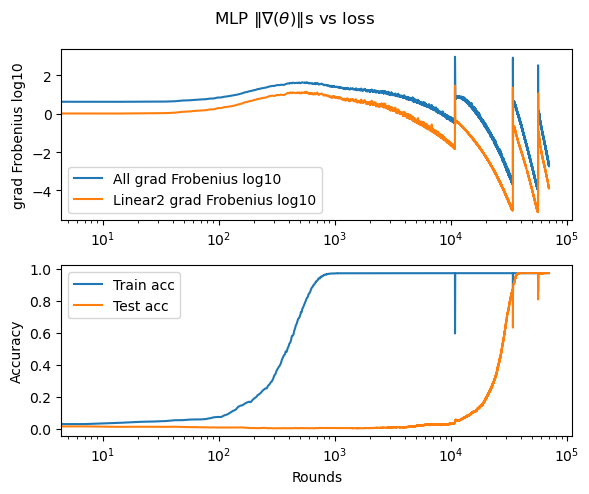

In [7]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,5))

ax1.plot(hessian_trainer.rounds_log, np.log10(hessian_trainer.all_curvature), label="All grad Frobenius log10")
ax1.plot(hessian_trainer.rounds_log, np.log10(hessian_trainer.l2_curvature), label="Linear2 grad Frobenius log10")
ax1.set_xscale("log")
ax1.set_ylabel("grad Frobenius log10")
ax1.legend()

ax2.plot(hessian_trainer.rounds_log, hessian_trainer.train_acc_log, label="Train acc")
ax2.plot(hessian_trainer.rounds_log, hessian_trainer.test_acc_log, label="Test acc")
ax2.set_xscale("log")
ax2.set_xlabel("Rounds")
ax2.set_ylabel("Accuracy")
ax2.legend()
fig.suptitle(r"MLP $\|\nabla(\theta)\|$s vs loss")
plt.tight_layout()
plt.savefig("MLP_curvatures.png",dpi=600)
plt.show()

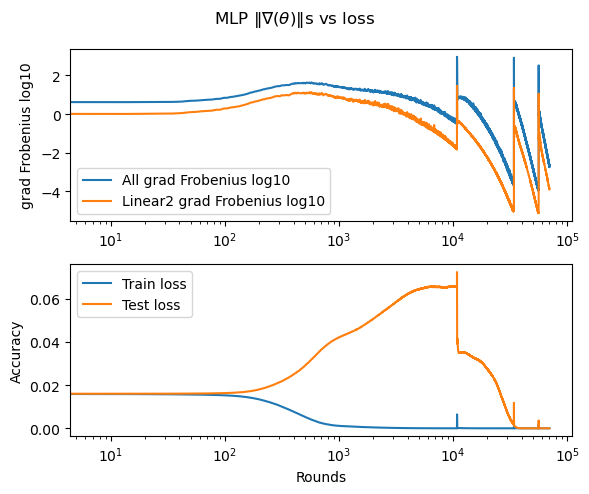

In [9]:
data = np.load("MLP_binary_59_256_AdamW_0.0005.npy").T
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,5))

ax1.plot(hessian_trainer.rounds_log, np.log10(hessian_trainer.all_curvature), label="All grad Frobenius log10")
ax1.plot(hessian_trainer.rounds_log, np.log10(hessian_trainer.l2_curvature), label="Linear2 grad Frobenius log10")
ax1.set_xscale("log")
ax1.set_ylabel("grad Frobenius log10")
ax1.legend()

ax2.plot(hessian_trainer.rounds_log, data[3], label="Train loss")
ax2.plot(hessian_trainer.rounds_log, data[4], label="Test loss")
ax2.set_xscale("log")
ax2.set_xlabel("Rounds")
ax2.set_ylabel("Accuracy")
ax2.legend()
fig.suptitle(r"MLP $\|\nabla(\theta)\|$s vs loss")
plt.tight_layout()
plt.savefig("MLP_curvatures_with_loss.png",dpi=600)
plt.show()